In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using AdaptiveTransportMap: transform!, evaluate, ncoeff, optimize, negative_log_likelihood!
using DiffResults
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using Polynomials
using Optim: InverseDiagonal
using MLDataUtils
using Test

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1260


In [3]:
function sample_banana(N)
    X = zeros(2,N)
    for i=1:N
        X[1,i] = randn()
        X[2,i] = X[1,i]^2 + randn()
    end
    return X
end

log_pdf_banana(X) = log_pdf(X[1]) + log_pdf(X[2] - X[1]^2)

log_pdf_banana (generic function with 1 method)

In [4]:
Ne = 1000
Nx = 2
m = 20

X = sample_banana(Ne)

2×1000 Array{Float64,2}:
 0.270932  1.18141   0.764136  -0.0354727  …   0.133437  -0.647015  -0.247518
 1.40311   0.597841  1.53577    2.7006        -1.8405     1.31184   -0.761791

In [5]:
M = HermiteMap(m, X);

In [6]:
L = LinearTransform(X; diag = false)

LinearTransform(2, [-0.012031985243711464, 1.0670686964866256], [1.0289491786974994 0.0; 0.07616377528062437 1.8649083322199487], false)

In [7]:
logdet(inv(L.L))

-0.6517499668744459

In [8]:
log_pdf(M[1], X[1:1,:])

1000-element Array{Float64,1}:
 -0.9556407128010057
 -1.6168077375648369
 -1.210890351136542
 -0.919567688944387
 -1.2374618772954968
 -1.31382325204346
 -0.9310259269875149
 -1.160715656586238
 -0.9538595309609742
 -0.9737686278468587
 -1.0518049550425004
 -1.2170491397231336
 -0.924572513259365
  ⋮
 -1.0912153447558883
 -0.9202398049261071
 -1.5522607843199037
 -0.9194848896660294
 -0.9701111479231156
 -1.0247278442462324
 -1.0982202467346065
 -1.2760674282972015
 -1.376705333185988
 -0.9278412202687423
 -1.1282529280093279
 -0.9495711753172222

In [86]:
@time optimize(M, X, "split");

  1.745868 seconds (282.08 k allocations: 1.396 GiB, 2.96% gc time)


In [87]:
MpushX = evaluate(M, X)

2×1000 Array{Float64,2}:
  1.07254    0.156895  -0.314425  …  -0.977173  -2.15585  -0.893224
 -0.0523654  1.10246    0.355493     -1.35625   -1.70964  -0.257463

In [88]:
S1 = Storage(M.C[1].I.f, X[1:1,:])
S2 = Storage(M.C[2].I.f, X[1:2,:]);

In [89]:
negative_log_likelihood!(0.0, nothing, getcoeff(M.C[1]), S1, M.C[1], X[1:1,:])

1.406916333891559

In [90]:
negative_log_likelihood!(0.0, nothing, getcoeff(M.C[2]), S2, M.C[2], X[1:2,:])

3.948519120065657

In [91]:
using Plots

In [77]:
Nlog = 500
logbanana = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)

xrange = range(-4.0; stop = 4.0, length = Nlog)
yrange = range(-3.0; stop = 12.0, length = Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y])
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

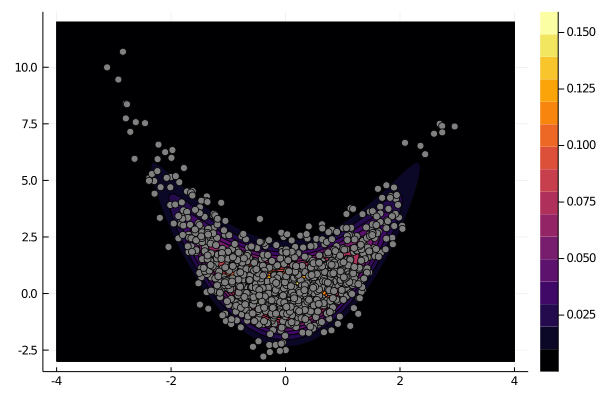

In [78]:
contourf(xrange, yrange, exp.(logbanana)')
scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

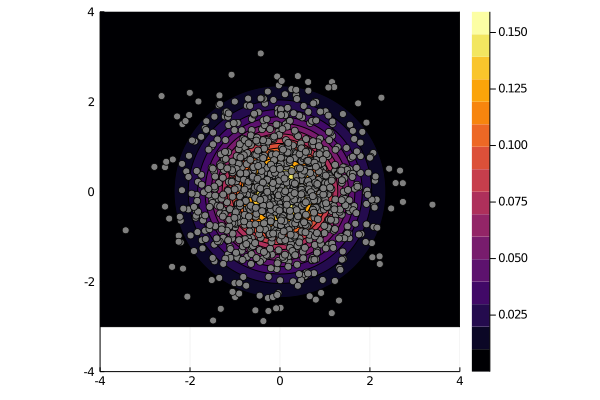

In [79]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [80]:
mean(MpushX; dims = 2)

2×1 Array{Float64,2}:
 -0.02738398845884643
  0.004751126254541861

In [81]:
cov(MpushX; dims = 2)

2×2 Array{Float64,2}:
 0.995578    0.00648776
 0.00648776  1.01252